# Chapter 20 - Blankenbach - Case1a

This notebook implements the Blankenbacch Case1a isoviscous thermal convection benchmark.

This notebook puts all of the major function definitions into separate source files and contains only the high-level program code.

In [1]:
# Import necessary packages
using SparseArrays
using LinearAlgebra
using IterativeSolvers
using WriteVTK
using Printf
using Statistics 
include("Grid.jl")
include("Markers.jl")
include("Stokes.jl")
include("Temperature.jl")
include("GridOperations.jl")

# note that we import pyplot last to avoid a name conflict with grid.
using PyPlot
include("Visualization.jl")

plots (generic function with 1 method)

## Model setup

Boundary conditions are insulating on the sides, fixed temperature top and bottom.

Initial condition is:
$$
T(x,y) = T_{surf} + \frac{(T_{btm}-T_{surf})}{H} y + dT\cos(\frac{\pi x}{W}) \sin(\frac{\pi y}{H})
$$

Note that the origin of the coordinate system is in the upper right. $y$ increases downward, $x$ increases rightward.

In [14]:
function blankenbach_initial_conditions!(markers::Markers,Ttop,Tbtm,W,H)
    eta = markers.scalarFields["eta"]
    T = markers.scalarFields["T"]
    for i in 1:markers.nmark
        mx = markers.x[1,i]
        my = markers.x[2,i]
        # T(x,y) = Tsurf + (Tbtm-Tsurf)/H * y + dT*cos(pi*x/W)
        markers.scalars[eta,i] = 1e23
        markers.scalars[T,i] = Ttop + (Tbtm-Ttop)/H*my + 10.0*cos(pi*mx/W)*sin(pi*my/H)
    end
end

function compute_nusselt(grid::CartesianGrid,T::Matrix{Float64},kThermal,Tbcval)
        dTdy = (T[2,:]-T[1,:])/(grid.yc[2]-grid.yc[1])
        kdTdy = kThermal*dTdy
        qcond = kThermal*(Tbcval[4]-Tbcval[3])/grid.H
        Nu = mean(kdTdy)/qcond;
    return Nu
end

function run_blankenbach_case1a(end_step=1;end_time=nothing)
    nx = 97
    ny = 97
    W = 1e6
    H = 1e6
    
    gx = 0.0
    gy = 10.0
    alpha = 2.5e-5; # thermal expansivity

    bc = BoundaryConditions(0,0,0,0) # currently does nothing but is required argument to stokes solver.
    Tbcval = [0.,0.,273.,1273.]   
    Tbctype = [-1,-1,1,1] # insulating left and right, isothermal top and bottom
    markx = 6
    marky = 6
    seconds_in_year = 3.15e7
    plot_interval = 100e6*seconds_in_year # plot interval in seconds
    dtmax = plot_interval
    
    grid = CartesianGrid(W,H,nx,ny)
    println("Creating Markers...")
    @time markers = Markers(grid,["T","rho","eta"],["material"] ; nmx=markx,nmy=marky,random=true)
    println("Initial condition...")
    @time blankenbach_initial_conditions!(markers,Tbcval[3],Tbcval[4],W,H)

    # define arrays for k, rho, cp, H at the basic nodes. Fill them with constant values for now.
    kThermal = 5.0 .*ones(grid.ny,grid.nx);
    Cp = 1250. .* ones(grid.ny,grid.nx);
    H = zeros(grid.ny,grid.nx);
    rho0 = 4000.0*ones(grid.ny,grid.nx);
    
    kappa = kThermal[1,1]/rho0[1,1]/Cp[1,1]
    diffusion_timescale = (grid.x[2]-grid.x[1])^2/kappa
    dtmax = minimum([dtmax,diffusion_timescale])
    
    local time = 0.0
    iout=0
    last_plot = 0.0

    local rho
    local rho_vx
    local rho_vy

    local eta_s
    local eta_n
    local T
    local dt
    local dTmax
    local dTemp
    local Tnew
    local Tlast
    
    nu_values=zeros(0)
    time_values=zeros(0)
    
    output_dir = "case1a"
    local terminate = false
    local itime=0
    while !terminate
        if itime >= end_step || (end_time != nothing && time >= end_time)
            terminate = true
        end
        
        rho_var = markers.scalarFields["rho"]
        T_var = markers.scalarFields["T"]
        for i in 1:markers.nmark
            markers.scalars[rho_var,i] = 4000.0*(1.0-alpha*(markers.scalars[T_var,i]-Tbcval[3]))
        end
        
        # Get density and viscosity from the markers.
        rho_new,eta_s_new = marker_to_stag(markers,grid,["rho","eta"],"basic");        
        eta_n_new,Tlast_new = marker_to_stag(markers,grid,["eta","T"],"center")
        rho_vx_new, = marker_to_stag(markers,grid,["rho",],"vx")
        rho_vy_new, = marker_to_stag(markers,grid,["rho",],"vy")
        
        if time > 0.0
            if any(isnan.(eta_s_new))
                println("found nan values")
            end
            replace_nan!(rho,rho_new)
            replace_nan!(Tlast,Tlast_new)
            replace_nan!(eta_s,eta_s_new)
            replace_nan!(eta_n,eta_n_new)
            replace_nan!(rho_vx,rho_vx_new)
            replace_nan!(rho_vy,rho_vy_new)
        end

        Tlast = copy(Tlast_new)
        rho   = copy(rho_new)
        eta_s = copy(eta_s_new) 
        eta_n = copy(eta_n_new)
        rho_vx = copy(rho_vx_new)
        rho_vy = copy(rho_vy_new)

        # assemble and solve the stokes equations
        L,R = form_stokes(grid,eta_s,eta_n,rho_vx,rho_vy,bc,gx,gy;dt=0.0) 
        solution = L\R
        vx,vy,P = unpack(solution,grid;ghost=true)
        vxc,vyc = velocity_to_centers(grid,vx,vy)
        dt = compute_timestep(grid,vxc,vyc;cfl=0.25,dtmax=dtmax)
        
        Tlast = ghost_temperature_center(grid,Tlast,Tbctype,Tbcval);

        dTmax = Inf
        for titer=1:2
            # assemble and solve the energy equation
            println("Trying with timestep ",dt)
            L,R = assemble_energy_equation_center(grid,rho0,Cp,kThermal,H,Tlast,dt,Tbcval);
            Tnew = L\R;
            Tnew = reshape(Tnew,grid.ny,grid.nx);
            Tnew = ghost_temperature_center(grid,Tnew,Tbctype,Tbcval);

            dTemp = Tnew-Tlast
            # compute the maximum temperature change
            dTmax = maximum(abs.(dTemp[2:end-1,2:end-1]))
            println("dTmax=",dTmax," dt=",dt/3.15e7/1e6)
            dt = min(dt,dTmax < 10.0 ? dt : dt*10.0/dTmax)
            if dTmax < 10.0
                break
            end
        end
        # compute Nusselt number
        Nu = compute_nusselt(grid,Tnew,kThermal[1,1],Tbcval)
        
        # store Nusselt number for plotting
        append!(nu_values,Nu)
        append!(time_values,time)
        
        dT_subgrid_node = subgrid_temperature_relaxation_center!(markers,grid,Tlast,Cp[1,1],kThermal[1,1],dt)
        dT_remaining = dTemp - dT_subgrid_node

        cell_center_change_to_markers!(markers,grid,dT_remaining,"T")

        if time == 0.0 || time - last_plot >= plot_interval || terminate
            last_plot = time 
            name = @sprintf("%s/viz.%04d.vtr",output_dir,iout)
            vn = velocity_to_basic_nodes(grid,vxc,vyc)

        visualization(grid,rho,eta_s,vn,P,Tnew[2:end-1,2:end-1],time/seconds_in_year;filename=name)
            name = @sprintf("%s/markers.%04d.vtp",output_dir,iout)
            visualization(markers,time/seconds_in_year;filename=name)
            iout += 1
        end

        move_markers_rk4!(markers,grid,vx,vy,dt,continuity_weight=1/3)
        time += dt
        itime += 1
        println("Finished Step ",itime," time=",time/seconds_in_year/1e6," Myr Nu=",Nu," ",extrema(Tnew[2:end-1,2:end-1]))
    end
    return nu_values, time_values, markers, grid, dTemp, Tnew, Tlast
end

run_blankenbach_case1a (generic function with 2 methods)

Run the benchmark code for 10 timesteps and produce a ProfileSVG view:

In [15]:
using ProfileSVG
@time nu,t,markers,grid,dTemp,Tnew,Tlast = run_blankenbach_case1a(10,end_time=6e9*3.15e7)

Creating Markers...
  0.001624 seconds (19 allocations: 22.023 MiB)
Initial condition...
  0.003261 seconds
Trying with timestep 1.0850694444444444e14
dTmax=0.8490222526643265 dt=3.444664902998236
  0.000371 seconds (2 allocations: 5.063 MiB)
Finished Step 1 time=3.444664902998236 Myr Nu=1.0530741354929056 (278.3046975422901, 1267.7061847482182)
Trying with timestep 1.0850694444444444e14
dTmax=0.6056833945674498 dt=3.444664902998236
Finished Step 2 time=6.889329805996472 Myr Nu=1.0347303288667817 (278.20913448136366, 1267.8005085235343)
Trying with timestep 1.0850694444444444e14
dTmax=0.4775698649361857 dt=3.444664902998236
Finished Step 3 time=10.333994708994709 Myr Nu=1.0242738178425235 (278.1519659392302, 1267.8568252929508)
Trying with timestep 1.0850694444444444e14
dTmax=0.4086512000330913 dt=3.444664902998236
Finished Step 4 time=13.778659611992945 Myr Nu=1.018296227028183 (278.1173397679092, 1267.89125075868)
Trying with timestep 1.0850694444444444e14
dTmax=0.3744725883564115 dt

([1.0530741354929056, 1.0347303288667817, 1.0242738178425235, 1.018296227028183, 1.0148263226464238, 1.0127640993765474, 1.0115009249620348, 1.0106988485846273, 1.0101705039341415, 1.0098089733345894, 1.0095518138239468], [0.0, 1.0850694444444444e14, 2.1701388888888888e14, 3.255208333333333e14, 4.3402777777777775e14, 5.425347222222222e14, 6.510416666666666e14, 7.59548611111111e14, 8.680555555555555e14, 9.765625e14, 1.0850694444444445e15], Markers([654.5440183158412 2599.7540709198656 … 0.0 0.0; 1147.748143718513 491.97043737169696 … 0.0 0.0], [1 1 … 0 0; 1 1 … 0 0], Dict{Any, Any}("T" => 1, "eta" => 3, "rho" => 2), [273.27860884288543 272.5827089964877 … 0.0 0.0; 3999.9719991525617 4000.041612729927 … 0.0 0.0; 1.0e23 1.0e23 … 0.0 0.0], Dict{Any, Any}("material" => 1), Int16[0 0 … 0 0], 331776, 398132), CartesianGrid([0.0, 10416.666666666666, 20833.333333333332, 31250.0, 41666.666666666664, 52083.333333333336, 62500.0, 72916.66666666667, 83333.33333333333, 93750.0  …  906250.0, 916666.6

Run the benchmark code long enough to approach steady state.

In [16]:
@time nu,t,markers,grid,dTemp,Tnew,Tlast = run_blankenbach_case1a(Inf,end_time=6e9*3.15e7);

Creating Markers...
  0.001819 seconds (19 allocations: 22.023 MiB)
Initial condition...
  0.003674 seconds
Trying with timestep 1.0850694444444444e14
dTmax=0.8306715540704772 dt=3.444664902998236
  0.000267 seconds (2 allocations: 5.063 MiB)
Finished Step 1 time=3.444664902998236 Myr Nu=1.0519980350382114 (278.28362676204586, 1267.7054126364537)
Trying with timestep 1.0850694444444444e14
dTmax=0.5965957497949148 dt=3.444664902998236
Finished Step 2 time=6.889329805996472 Myr Nu=1.0339783061950558 (278.1916118728063, 1267.7948166712986)
Trying with timestep 1.0850694444444444e14
dTmax=0.48040138680244127 dt=3.444664902998236
Finished Step 3 time=10.333994708994709 Myr Nu=1.0237073836902177 (278.13730452831317, 1267.8487628558555)
Trying with timestep 1.0850694444444444e14
dTmax=0.4303226743875257 dt=3.444664902998236
Finished Step 4 time=13.778659611992945 Myr Nu=1.0178428225235385 (278.1044365046338, 1267.8820155949165)
Trying with timestep 1.0850694444444444e14
dTmax=0.41030432347201

Trying with timestep 1.0850694444444444e14
dTmax=0.3821050097619718 dt=3.444664902998236
Finished Step 42 time=144.67592592592598 Myr Nu=1.0105416576883308 (277.7877567799787, 1268.2029684173378)
Trying with timestep 1.0850694444444444e14
dTmax=0.3787521151373312 dt=3.444664902998236
Finished Step 43 time=148.12059082892418 Myr Nu=1.0107223843227446 (277.7770500461385, 1268.213454390554)
Trying with timestep 1.0850694444444444e14
dTmax=0.37117023034102203 dt=3.444664902998236
Finished Step 44 time=151.5652557319224 Myr Nu=1.0109178380959796 (277.7662382397282, 1268.224272703932)
Trying with timestep 1.0850694444444444e14
dTmax=0.3575905771622274 dt=3.444664902998236
Finished Step 45 time=155.00992063492063 Myr Nu=1.0111222439139433 (277.7551144883466, 1268.235234328141)
Trying with timestep 1.0850694444444444e14
dTmax=0.3583880756552844 dt=3.444664902998236
Finished Step 46 time=158.45458553791886 Myr Nu=1.0113376660421545 (277.74367426641186, 1268.2464645403152)
Trying with timestep 1

Trying with timestep 1.0850694444444444e14
dTmax=0.4641157532548732 dt=3.444664902998236
Finished Step 84 time=289.3518518518513 Myr Nu=1.0380470782189177 (277.07318268750157, 1268.927711270362)
Trying with timestep 1.0850694444444444e14
dTmax=0.45830571593614877 dt=3.444664902998236
Finished Step 85 time=292.79651675484956 Myr Nu=1.0396695132637954 (277.04811321399745, 1268.9537304626535)
Trying with timestep 1.0850694444444444e14
dTmax=0.45548577273325463 dt=3.444664902998236
Finished Step 86 time=296.2411816578478 Myr Nu=1.041373699527383 (277.0222112112704, 1268.979621566304)
Trying with timestep 1.0850694444444444e14
dTmax=0.45482690114198476 dt=3.444664902998236
Finished Step 87 time=299.68584656084596 Myr Nu=1.043165825618644 (276.9959599656126, 1269.0062521626503)
Trying with timestep 1.0850694444444444e14
dTmax=0.44975202357130684 dt=3.444664902998236
Finished Step 88 time=303.1305114638442 Myr Nu=1.0450498317904187 (276.96914992851805, 1269.0336636776735)
Trying with timestep

Trying with timestep 5.90359125131526e13
dTmax=0.6023879254166786 dt=1.8741559527984952
Finished Step 126 time=400.2787104736148 Myr Nu=1.174596718691254 (276.00174240940584, 1270.0037226093336)
Trying with timestep 5.829501974441051e13
dTmax=0.5869201112038809 dt=1.8506355474416034
Finished Step 127 time=402.12934602105634 Myr Nu=1.1792327870051658 (275.97976068902966, 1270.026314114067)
Trying with timestep 5.757410012297859e13
dTmax=0.579078197266881 dt=1.8277492102532888
Finished Step 128 time=403.95709523130967 Myr Nu=1.183934095697223 (275.9577765878006, 1270.0483354032344)
Trying with timestep 5.687232642662264e13
dTmax=0.5764005069836458 dt=1.8054706802102425
Finished Step 129 time=405.76256591151986 Myr Nu=1.1887049820810147 (275.9363968121137, 1270.0701866058098)
Trying with timestep 5.618901169286623e13
dTmax=0.5723261317825745 dt=1.78377814897988
Finished Step 130 time=407.54634406049973 Myr Nu=1.1935176769870044 (275.91516207268205, 1270.092502218465)
Trying with timestep 

Trying with timestep 3.9205676015721836e13
dTmax=0.6357403625346478 dt=1.2446246354197408
Finished Step 168 time=463.4070959266903 Myr Nu=1.424685656436803 (275.2116575571917, 1270.8022963832689)
Trying with timestep 3.891485641311915e13
dTmax=0.6627009804366821 dt=1.2353922670831476
Finished Step 169 time=464.6424881937735 Myr Nu=1.4320176763765942 (275.1956966877017, 1270.816643561374)
Trying with timestep 3.862934622553787e13
dTmax=0.6885898341197958 dt=1.2263284516043769
Finished Step 170 time=465.86881664537793 Myr Nu=1.4394392435553103 (275.1804830918795, 1270.8308045701895)
Trying with timestep 3.834903805962531e13
dTmax=0.646646983533401 dt=1.2174297796706448
Finished Step 171 time=467.0862464250486 Myr Nu=1.4469904566842806 (275.16488057161547, 1270.8454606338569)
Trying with timestep 3.807376895165996e13
dTmax=0.6938516054395336 dt=1.2086910778304751
Finished Step 172 time=468.294937502879 Myr Nu=1.4545850460985683 (275.1499047435655, 1270.8599073873352)
Trying with timestep 

Trying with timestep 3.0423786419429805e13
dTmax=0.8162804333202303 dt=0.965834489505708
Finished Step 210 time=509.0154238633731 Myr Nu=1.7973326157446803 (274.6462708177283, 1271.3643901780788)
Trying with timestep 3.027814209300731e13
dTmax=0.8636900331155175 dt=0.9612108600954701
Finished Step 211 time=509.9766347234685 Myr Nu=1.807751081219247 (274.6353432235337, 1271.375143756723)
Trying with timestep 3.0134660606191086e13
dTmax=0.8350415420236459 dt=0.9566558922600344
Finished Step 212 time=510.9332906157286 Myr Nu=1.8182598197570496 (274.6247449665826, 1271.3858993030988)
Trying with timestep 2.9993290658150707e13
dTmax=0.8873070096778974 dt=0.9521679574016098
Finished Step 213 time=511.8854585731302 Myr Nu=1.8288681355343186 (274.614309290787, 1271.3965432931332)
Trying with timestep 2.9854007944703844e13
dTmax=0.9673023536515757 dt=0.9477462839588522
  0.000267 seconds (2 allocations: 5.063 MiB)
Finished Step 214 time=512.8332048570891 Myr Nu=1.8395665602054998 (274.603780554

Trying with timestep 2.5808060543420203e13
dTmax=1.5017837207549292 dt=0.819303509314927
Finished Step 252 time=546.1240167402394 Myr Nu=2.3008443896227866 (274.26498592118986, 1271.7432016268485)
Trying with timestep 2.5728211061634336e13
dTmax=1.5179918124615597 dt=0.8167686051312487
Finished Step 253 time=546.9407853453706 Myr Nu=2.314416016856926 (274.2578634898035, 1271.750959403994)
Trying with timestep 2.5649469744848125e13
dTmax=1.4979046787270818 dt=0.8142688807888294
Finished Step 254 time=547.7550542261595 Myr Nu=2.3280482861583547 (274.2506485026883, 1271.758799808823)
Trying with timestep 2.5571830060843137e13
dTmax=1.4025618049445256 dt=0.8118041289156551
Finished Step 255 time=548.5668583550752 Myr Nu=2.3416164701410573 (274.2435278997753, 1271.7666122936598)
Trying with timestep 2.549527549637201e13
dTmax=1.4565435456547675 dt=0.8093738252816511
Finished Step 256 time=549.3762321803569 Myr Nu=2.3555214190107763 (274.23639233704125, 1271.774406540339)
Trying with timeste

Trying with timestep 2.326404081138304e13
dTmax=2.0013905859166243 dt=0.7385409781391441
Finished Step 294 time=578.6290804535367 Myr Nu=2.9343299715276436 (274.0060591314647, 1272.007643676239)
Trying with timestep 2.322066394508834e13
dTmax=2.0287002532299994 dt=0.7371639347647092
Finished Step 295 time=579.3662443883015 Myr Nu=2.9510103192211186 (274.0019012111712, 1272.01343951366)
Trying with timestep 2.3177971408145363e13
dTmax=2.0908870189180107 dt=0.7358086161315989
Finished Step 296 time=580.1020530044331 Myr Nu=2.967796951762736 (273.9978122742323, 1272.018839120654)
Trying with timestep 2.3135957425385652e13
dTmax=2.1463418094999724 dt=0.7344748389011317
Finished Step 297 time=580.8365278433341 Myr Nu=2.98434415956098 (273.99380190993827, 1272.0241586352377)
Trying with timestep 2.309461970933117e13
dTmax=2.011067070842728 dt=0.7331625304549578
Finished Step 298 time=581.5696903737891 Myr Nu=3.000709175041744 (273.9896109820576, 1272.0293316466057)
Trying with timestep 2.305

Trying with timestep 2.196782947166614e13
dTmax=2.7257120904162093 dt=0.6973914117989252
Finished Step 336 time=608.650031296884 Myr Nu=3.6774522943982695 (273.8617030683371, 1272.161935965923)
Trying with timestep 2.1948693396669516e13
dTmax=2.7920280549772087 dt=0.6967839173545878
Finished Step 337 time=609.3468152142385 Myr Nu=3.696144937396172 (273.8595186319147, 1272.1642689944972)
Trying with timestep 2.1930049308092707e13
dTmax=2.698437760254592 dt=0.6961920415267526
Finished Step 338 time=610.0430072557652 Myr Nu=3.7149456854554117 (273.8573059688162, 1272.1664932162066)
Trying with timestep 2.1911896752888855e13
dTmax=2.611907638087814 dt=0.6956157699329795
Finished Step 339 time=610.7386230256982 Myr Nu=3.733958267594479 (273.85535356819315, 1272.1688649900457)
Trying with timestep 2.189423187494e13
dTmax=2.411031229938544 dt=0.6950549801568254
Finished Step 340 time=611.433678005855 Myr Nu=3.7525837432546547 (273.8533053475146, 1272.171323099536)
Trying with timestep 2.18770

Trying with timestep 2.1452397156491668e13
dTmax=3.116093221914298 dt=0.6810284811584656
Finished Step 378 time=637.5443907489314 Myr Nu=4.488233043477283 (273.7955134169538, 1272.2207663923193)
Trying with timestep 2.144454591576944e13
dTmax=3.0998783398854357 dt=0.6807792354212521
Finished Step 379 time=638.2251699843525 Myr Nu=4.507585047104905 (273.79483606649814, 1272.2214795152715)
Trying with timestep 2.143703603982834e13
dTmax=2.9253275968501384 dt=0.6805408266612172
Finished Step 380 time=638.9057108110138 Myr Nu=4.527187015066225 (273.79415865687037, 1272.2220503997005)
Trying with timestep 2.142987204789189e13
dTmax=2.8687475136523517 dt=0.6803133983457743
Finished Step 381 time=639.5860242093596 Myr Nu=4.5473823322260065 (273.7934333752806, 1272.2224539057268)
Trying with timestep 2.1423047059999008e13
dTmax=3.0285577937729613 dt=0.6800967320634606
Finished Step 382 time=640.2661209414231 Myr Nu=4.567828880980632 (273.79272179124274, 1272.2224940033127)
Trying with timestep

Trying with timestep 2.1391700884732176e13
dTmax=3.350283134795802 dt=0.679101615388323
Finished Step 420 time=666.0470372895275 Myr Nu=5.298664737441643 (273.81610275822675, 1272.18966632368)
Trying with timestep 2.1396694814210777e13
dTmax=3.444610394298934 dt=0.6792601528320882
Finished Step 421 time=666.7262974423594 Myr Nu=5.318005799209661 (273.8180810432521, 1272.186907267687)
Trying with timestep 2.1401989510887023e13
dTmax=4.254581769119795 dt=0.6794282384408579
Finished Step 422 time=667.4057256808004 Myr Nu=5.337594389619828 (273.82008041541314, 1272.1842364229287)
Trying with timestep 2.1407571016448746e13
dTmax=4.8251583685353125 dt=0.679605429093611
Finished Step 423 time=668.0853311098939 Myr Nu=5.356794217785747 (273.8223905771843, 1272.1816273318427)
Trying with timestep 2.1413439896114062e13
dTmax=5.045247772511175 dt=0.6797917427337797
Finished Step 424 time=668.7651228526278 Myr Nu=5.375012393054087 (273.8248906216434, 1272.1788219780674)
Trying with timestep 2.1419

Trying with timestep 2.1863127440524297e13
dTmax=5.003096076361999 dt=0.6940675377944221
Finished Step 463 time=695.5191102394193 Myr Nu=6.0506488485511 (273.9475163513759, 1272.0509102642638)
Trying with timestep 2.187998157725317e13
dTmax=5.556151795205551 dt=0.694602589754069
Finished Step 464 time=696.2137128291733 Myr Nu=6.068204187869617 (273.95052506568686, 1272.0457200143112)
Trying with timestep 2.1897113257030227e13
dTmax=5.319099578689816 dt=0.6951464526041342
Finished Step 465 time=696.9088592817775 Myr Nu=6.084777394908902 (273.9532287388296, 1272.0402017449255)
Trying with timestep 2.1914519720276535e13
dTmax=4.870806066579462 dt=0.6956990387389376
Finished Step 466 time=697.6045583205165 Myr Nu=6.099032908031941 (273.95585860021714, 1272.0341398978567)
Trying with timestep 2.1932202503870586e13
dTmax=4.501252368813084 dt=0.6962603969482726
Finished Step 467 time=698.3008187174648 Myr Nu=6.113311449682484 (273.9584476627014, 1272.0280940737127)
Trying with timestep 2.1950

Trying with timestep 2.2812662020117285e13
dTmax=5.183788588890593 dt=0.724211492702136
Finished Step 505 time=725.2627789834386 Myr Nu=6.639444522051689 (274.13531749891195, 1271.783108899956)
Trying with timestep 2.2841384471637e13
dTmax=5.231320517900713 dt=0.7251233165599047
Finished Step 506 time=725.9879022999985 Myr Nu=6.650849542502342 (274.14220352484483, 1271.7753959894226)
Trying with timestep 2.2870389456281105e13
dTmax=6.508430458248597 dt=0.7260441097232098
Finished Step 507 time=726.7139464097216 Myr Nu=6.664755036570413 (274.14922235152386, 1271.7674930030037)
Trying with timestep 2.2899682652936203e13
dTmax=7.116288394938977 dt=0.7269740524741652
Finished Step 508 time=727.4409204621958 Myr Nu=6.677667818968061 (274.15591913041476, 1271.7594728511776)
Trying with timestep 2.292927823771375e13
dTmax=6.654583207199266 dt=0.7279135948480555
Finished Step 509 time=728.1688340570438 Myr Nu=6.689036626066044 (274.1630197501556, 1271.7518445296907)
Trying with timestep 2.2959

Trying with timestep 2.4309517389965402e13
dTmax=7.070991686066918 dt=0.7717307107925524
Finished Step 548 time=757.388294920395 Myr Nu=7.061627333317273 (274.52203386773846, 1271.4420823082448)
Trying with timestep 2.4350913003034535e13
dTmax=7.298451693468678 dt=0.7730448572391916
Finished Step 549 time=758.1613397776342 Myr Nu=7.067242430442949 (274.53298328321677, 1271.4368058438645)
Trying with timestep 2.4392621416369965e13
dTmax=7.387268936626242 dt=0.7743689338530148
Finished Step 550 time=758.9357087114873 Myr Nu=7.074188586718949 (274.5434800072423, 1271.4318760337196)
Trying with timestep 2.443463538020966e13
dTmax=7.417282595281222 dt=0.7757027104828463
Finished Step 551 time=759.71141142197 Myr Nu=7.082565811147029 (274.55397540275203, 1271.426890678122)
Trying with timestep 2.4476962773247766e13
dTmax=7.435043185163067 dt=0.7770464372459608
Finished Step 552 time=760.4884578592159 Myr Nu=7.090558072908581 (274.56472779061124, 1271.4210663554293)
Trying with timestep 2.451

Trying with timestep 2.6386505553359668e13
dTmax=6.290011965653775 dt=0.837666842963799
Finished Step 591 time=791.9527217889986 Myr Nu=7.267416133800079 (274.97747095719313, 1271.0527935597759)
Trying with timestep 2.644236109480911e13
dTmax=6.227936914482939 dt=0.8394400347558447
Finished Step 592 time=792.7921618237544 Myr Nu=7.271066296656267 (274.98763063426196, 1271.0410116680919)
Trying with timestep 2.6498584159975562e13
dTmax=6.74007337781137 dt=0.8412248939674782
Finished Step 593 time=793.6333867177219 Myr Nu=7.274370876813806 (274.99760188024214, 1271.0296970843387)
Trying with timestep 2.6555130636301758e13
dTmax=6.288975279475096 dt=0.8430200202000558
Finished Step 594 time=794.4764067379219 Myr Nu=7.276388796129113 (275.00737506366426, 1271.0178125922193)
Trying with timestep 2.661203212980683e13
dTmax=5.5801820111935285 dt=0.8448264168192644
Finished Step 595 time=795.3212331547412 Myr Nu=7.277946120707286 (275.01784452070547, 1271.0051995151582)
Trying with timestep 2.

Trying with timestep 2.9040864835724195e13
dTmax=6.176331092710711 dt=0.9219322170071174
Finished Step 633 time=828.8754444608064 Myr Nu=7.284803682776388 (275.4511975530098, 1270.479728863933)
Trying with timestep 2.9112117328903805e13
dTmax=6.331354996809978 dt=0.9241942009175811
Finished Step 634 time=829.799638661724 Myr Nu=7.282560876170398 (275.46727237929525, 1270.4676298246268)
Trying with timestep 2.9183750750825645e13
dTmax=6.441001823495753 dt=0.9264682778039887
Finished Step 635 time=830.7261069395279 Myr Nu=7.281421771258022 (275.48308128584364, 1270.4559496030051)
Trying with timestep 2.925573857069266e13
dTmax=6.328072381635593 dt=0.9287536054188146
Finished Step 636 time=831.6548605449467 Myr Nu=7.280488213859441 (275.4982556629194, 1270.4441990892365)
Trying with timestep 2.932811490274087e13
dTmax=6.236853493990338 dt=0.9310512667536784
Finished Step 637 time=832.5859118117004 Myr Nu=7.279077497112306 (275.51310628258557, 1270.4320474257624)
Trying with timestep 2.940

Trying with timestep 3.246260068716168e13
dTmax=6.384506910141056 dt=1.0305587519733865
Finished Step 676 time=870.824206231802 Myr Nu=7.137365508121541 (276.0753889162814, 1269.9396583241423)
Trying with timestep 3.2551014577599227e13
dTmax=6.364201293524616 dt=1.0333655421460073
Finished Step 677 time=871.857571773948 Myr Nu=7.132950400326246 (276.09082589587246, 1269.9253871836681)
Trying with timestep 3.263982011921784e13
dTmax=6.978091986805339 dt=1.0361847656894552
Finished Step 678 time=872.8937565396375 Myr Nu=7.127371630611005 (276.10610925601435, 1269.9112040560399)
Trying with timestep 3.272903318172619e13
dTmax=7.302127598226889 dt=1.0390169264040061
Finished Step 679 time=873.9327734660416 Myr Nu=7.121025710797468 (276.12107223958697, 1269.8965094279129)
Trying with timestep 3.2818627503556746e13
dTmax=6.918857377331051 dt=1.041861190589103
Finished Step 680 time=874.9746346566307 Myr Nu=7.114573743859751 (276.13645033679614, 1269.88061426999)
Trying with timestep 3.290863

Trying with timestep 3.649968609747409e13
dTmax=6.169248699492982 dt=1.1587201935706062
Finished Step 718 time=916.7907789116704 Myr Nu=6.839937173642853 (276.73411002626653, 1269.2944717374792)
Trying with timestep 3.660365510873494e13
dTmax=6.457770994190241 dt=1.1620207971026966
Finished Step 719 time=917.9527997087731 Myr Nu=6.831603975267411 (276.74746753589443, 1269.2805578441335)
Trying with timestep 3.6708034224468266e13
dTmax=6.6371685692311075 dt=1.1653344198243893
Finished Step 720 time=919.1181341285975 Myr Nu=6.824002994648062 (276.75997612255986, 1269.2646696305387)
Trying with timestep 3.681276139183769e13
dTmax=6.5971777393661455 dt=1.1686590918043709
Finished Step 721 time=920.2867932204018 Myr Nu=6.816187649440058 (276.77204704454215, 1269.24955509198)
Trying with timestep 3.6917790925430414e13
dTmax=6.406559141281207 dt=1.1719933627120767
Finished Step 722 time=921.4587865831139 Myr Nu=6.807371468862526 (276.7841514923937, 1269.2355862418124)
Trying with timestep 3.7

Trying with timestep 4.124770415115596e13
dTmax=6.407518730395907 dt=1.3094509254335225
Finished Step 761 time=969.872590771199 Myr Nu=6.438009890543651 (277.31611911936454, 1268.7244258131027)
Trying with timestep 4.136363108937342e13
dTmax=6.343515885508225 dt=1.3131311456943944
Finished Step 762 time=971.1857219168934 Myr Nu=6.4274713453991295 (277.32900275910043, 1268.715261594193)
Trying with timestep 4.14797541295002e13
dTmax=6.291694585978405 dt=1.316817591412705
Finished Step 763 time=972.502539508306 Myr Nu=6.4175726100212005 (277.340621497088, 1268.7054329442876)
Trying with timestep 4.159610364020925e13
dTmax=6.214259592234839 dt=1.3205112266733094
Finished Step 764 time=973.8230507349792 Myr Nu=6.40793725654328 (277.35147571731744, 1268.696415577662)
Trying with timestep 4.171262255298235e13
dTmax=6.4091952614489855 dt=1.3242102397772175
Finished Step 765 time=975.1472609747566 Myr Nu=6.398331190617304 (277.36228773362495, 1268.6856106548084)
Trying with timestep 4.18292619

Trying with timestep 4.618172557230357e13
dTmax=5.735493856015069 dt=1.4660865261048752
Finished Step 803 time=1028.228999114821 Myr Nu=5.9844122604223315 (277.6513589752386, 1268.2747956026458)
Trying with timestep 4.629910281074653e13
dTmax=6.23781839586411 dt=1.469812787642747
Finished Step 804 time=1029.6988119024636 Myr Nu=5.973374332759625 (277.65322619663704, 1268.263008870777)
Trying with timestep 4.641629005127239e13
dTmax=6.014951778763532 dt=1.4735330175007109
Finished Step 805 time=1031.1723449199644 Myr Nu=5.962243543736892 (277.6566603395934, 1268.2514531324687)
Trying with timestep 4.6533305321484055e13
dTmax=5.4518606018922355 dt=1.4772477879836208
Finished Step 806 time=1032.649592707948 Myr Nu=5.951452211936166 (277.66107980336125, 1268.2408205401787)
Trying with timestep 4.6650279269783945e13
dTmax=5.476867857394836 dt=1.4809612466598079
Finished Step 807 time=1034.1305539546076 Myr Nu=5.9401065772816635 (277.6645613268469, 1268.2313116084376)
Trying with timestep 4.

Finished Step 845 time=1093.0868943611902 Myr Nu=5.509782973820331 (277.7785988876605, 1268.012163685682)
Trying with timestep 5.100842791778478e13
dTmax=5.293204863036067 dt=1.6193151719931675
Finished Step 846 time=1094.7062095331833 Myr Nu=5.49887910360377 (277.78320314647226, 1268.0099338883226)
Trying with timestep 5.111231929717079e13
dTmax=5.275283231464755 dt=1.6226133110212948
Finished Step 847 time=1096.3288228442048 Myr Nu=5.4886145696564 (277.7875752124228, 1268.007757327118)
Trying with timestep 5.121578883039264e13
dTmax=5.165514476359476 dt=1.625898058107703
Finished Step 848 time=1097.9547209023124 Myr Nu=5.478194559530252 (277.7924698391349, 1268.006602000706)
Trying with timestep 5.131862025765035e13
dTmax=5.193624120781124 dt=1.629162547861916
Finished Step 849 time=1099.5838834501744 Myr Nu=5.466853882857809 (277.79664751855506, 1268.0060551121876)
Trying with timestep 5.1420807585863055e13
dTmax=5.89624941292368 dt=1.6324065900273987
Finished Step 850 time=1101.216

Trying with timestep 5.480910224857341e13
dTmax=5.755443301198284 dt=1.7399714999547113
Finished Step 888 time=1165.4520490692025 Myr Nu=5.04995497961933 (277.9006645600072, 1268.045370583897)
Trying with timestep 5.488290833794564e13
dTmax=5.470136289638617 dt=1.7423145504109727
Finished Step 889 time=1167.1943636196133 Myr Nu=5.039270084470628 (277.90023903811704, 1268.0466868232868)
Trying with timestep 5.495581630783596e13
dTmax=5.123047231035798 dt=1.7446290891376497
Finished Step 890 time=1168.938992708751 Myr Nu=5.029359532952245 (277.8985407251571, 1268.04773628407)
Trying with timestep 5.5027710889383695e13
dTmax=5.231128110531131 dt=1.7469114568058315
Finished Step 891 time=1170.6859041655568 Myr Nu=5.020105546033975 (277.8970255240741, 1268.0471611897444)
Trying with timestep 5.509859809596718e13
dTmax=5.30555786171999 dt=1.7491618443164185
Finished Step 892 time=1172.4350660098733 Myr Nu=5.0105050346104925 (277.89656036283964, 1268.047351749766)
Trying with timestep 5.51686

Trying with timestep 5.705979230198115e13
dTmax=5.969178980155789 dt=1.8114219778406713
Finished Step 930 time=1240.2660177181508 Myr Nu=4.65319088928144 (277.8607141602757, 1268.1428304678877)
Trying with timestep 5.709108971473135e13
dTmax=5.754833022593516 dt=1.812415546499408
Finished Step 931 time=1242.0784332646501 Myr Nu=4.64504266168279 (277.8573594630799, 1268.1478882330118)
Trying with timestep 5.7121331930777086e13
dTmax=5.594746313679138 dt=1.8133756168500663
Finished Step 932 time=1243.8918088815003 Myr Nu=4.637293908866233 (277.85494924611305, 1268.154942985187)
Trying with timestep 5.7150160731615664e13
dTmax=5.468197023361313 dt=1.8142908168766878
Finished Step 933 time=1245.7060996983769 Myr Nu=4.629383654896939 (277.85291848416574, 1268.162939003093)
Trying with timestep 5.7177931900248e13
dTmax=5.36601580583806 dt=1.8151724412777142
Finished Step 934 time=1247.5212721396547 Myr Nu=4.620706404553002 (277.85041546916995, 1268.171278001435)
Trying with timestep 5.720503

Trying with timestep 5.743015672019614e13
dTmax=5.662210629071069 dt=1.823179578418925
  0.000231 seconds (2 allocations: 5.063 MiB)
Finished Step 973 time=1318.6395170227872 Myr Nu=4.324278365592506 (277.7055717095344, 1268.337111493741)
Trying with timestep 5.741586579734809e13
dTmax=5.494696152941401 dt=1.8227258983285108
Finished Step 974 time=1320.4622429211158 Myr Nu=4.317302834598223 (277.701410453019, 1268.3444255535467)
Trying with timestep 5.7400671500035445e13
dTmax=5.278018283493907 dt=1.822243539683665
Finished Step 975 time=1322.2844864607994 Myr Nu=4.3102415405741485 (277.6960829375095, 1268.3521283491248)
Trying with timestep 5.738439433237471e13
dTmax=5.044061665862728 dt=1.8217268042023718
Finished Step 976 time=1324.106213265002 Myr Nu=4.303702719272369 (277.6920694953452, 1268.359404513079)
Trying with timestep 5.736701224507566e13
dTmax=4.88762264754223 dt=1.8211749919071638
Finished Step 977 time=1325.927388256909 Myr Nu=4.297831570788216 (277.687146966549, 1268.3

Trying with timestep 5.602510166528679e13
dTmax=4.768181788018637 dt=1.7785746560408506
Finished Step 1015 time=1394.4271751740803 Myr Nu=4.084942297676912 (277.4922934816812, 1268.5770847662843)
Trying with timestep 5.597417528164545e13
dTmax=4.5376540414489455 dt=1.7769579454490618
Finished Step 1016 time=1396.2041331195294 Myr Nu=4.080153258417686 (277.4876958790305, 1268.5850218773264)
Trying with timestep 5.592254255911195e13
dTmax=4.349277573026143 dt=1.7753188114003795
Finished Step 1017 time=1397.9794519309296 Myr Nu=4.075190730335556 (277.48360013581873, 1268.591830952893)
Trying with timestep 5.587027882762144e13
dTmax=4.226251651522148 dt=1.7736596453213154
Finished Step 1018 time=1399.7531115762513 Myr Nu=4.0704316225762875 (277.47869687889465, 1268.5979008845302)
Trying with timestep 5.5817448332861305e13
dTmax=4.053073014400638 dt=1.7719824867575018
Finished Step 1019 time=1401.5250940630087 Myr Nu=4.065949633929139 (277.4731369310082, 1268.6041302213205)
Trying with time

Trying with timestep 5.3376496868616836e13
dTmax=4.73416074438569 dt=1.6944919640830742
Finished Step 1057 time=1467.427453291747 Myr Nu=3.9234826542098165 (277.19095689217636, 1268.819918985706)
Trying with timestep 5.330316541941402e13
dTmax=4.577687645733022 dt=1.6921639815686993
Finished Step 1058 time=1469.119617273316 Myr Nu=3.9208025198226464 (277.18484122725425, 1268.8269373112735)
Trying with timestep 5.322954036904098e13
dTmax=4.549997692746047 dt=1.6898266783822533
Finished Step 1059 time=1470.809443951698 Myr Nu=3.9180740174830344 (277.1786001047558, 1268.833532314101)
Trying with timestep 5.315548718716372e13
dTmax=4.575362410558228 dt=1.6874757837194831
Finished Step 1060 time=1472.4969197354174 Myr Nu=3.915143150422183 (277.17085911156994, 1268.8410108445396)
Trying with timestep 5.308109371660327e13
dTmax=4.569383797326509 dt=1.6851140862413738
Finished Step 1061 time=1474.1820338216587 Myr Nu=3.912337995773654 (277.1628352316695, 1268.8480655521194)
Trying with timeste

Trying with timestep 5.009331716174656e13
dTmax=4.004715327799772 dt=1.5902640368808434
Finished Step 1099 time=1536.393757502729 Myr Nu=3.835632629930721 (276.7945326398989, 1269.1290749142368)
Trying with timestep 5.001156043714263e13
dTmax=3.9786235931223928 dt=1.5876685853061152
Finished Step 1100 time=1537.981426088035 Myr Nu=3.834471549078533 (276.7879555814925, 1269.137984378704)
Trying with timestep 4.992972180490027e13
dTmax=4.14464740799292 dt=1.5850705334888977
Finished Step 1101 time=1539.566496621524 Myr Nu=3.8339228761464583 (276.7827267749352, 1269.1466562048845)
Trying with timestep 4.984781958781155e13
dTmax=4.217547533953962 dt=1.5824704631051283
Finished Step 1102 time=1541.148967084629 Myr Nu=3.8327538538919805 (276.77779371855746, 1269.1539547709676)
Trying with timestep 4.9765924072764305e13
dTmax=4.20796482998162 dt=1.579870605484581
Finished Step 1103 time=1542.7288376901138 Myr Nu=3.831097788158582 (276.77374809390443, 1269.1622677447322)
Trying with timestep 4

Trying with timestep 4.668461777473488e13
dTmax=4.020823156861525 dt=1.4820513579280914
Finished Step 1141 time=1600.8463588754419 Myr Nu=3.8139459526654615 (276.53332748461906, 1269.481598533989)
Trying with timestep 4.660530211307792e13
dTmax=4.0658901515364505 dt=1.4795334004151721
Finished Step 1142 time=1602.3258922758569 Myr Nu=3.8136329925326713 (276.5275508422342, 1269.488457376886)
Trying with timestep 4.652622729110266e13
dTmax=4.09564061632318 dt=1.4770230886064335
Finished Step 1143 time=1603.8029153644636 Myr Nu=3.8138739786144606 (276.52048136098216, 1269.4944166033965)
Trying with timestep 4.644739470622168e13
dTmax=3.7387222844648704 dt=1.4745204668641803
Finished Step 1144 time=1605.2774358313277 Myr Nu=3.814207964803694 (276.51365375624965, 1269.499563202759)
Trying with timestep 4.636860791022605e13
dTmax=3.9733448048941113 dt=1.4720192987373348
Finished Step 1145 time=1606.749455130065 Myr Nu=3.8142390484071376 (276.5062370850753, 1269.5040976383254)
Trying with tim

Trying with timestep 4.349069628365271e13
dTmax=3.803025914979571 dt=1.380657024877864
Finished Step 1183 time=1660.8782219280106 Myr Nu=3.8439088262948307 (276.2600526798413, 1269.6730589339343)
Trying with timestep 4.341895136534924e13
dTmax=3.7586203053274403 dt=1.3783794084237853
Finished Step 1184 time=1662.2566013364346 Myr Nu=3.845697481432222 (276.25233436046443, 1269.6782190401432)
Trying with timestep 4.3347466447055516e13
dTmax=3.5516120305287586 dt=1.3761100459382705
Finished Step 1185 time=1663.632711382373 Myr Nu=3.8477405966949907 (276.2438818863923, 1269.6830553619197)
Trying with timestep 4.327610213420826e13
dTmax=3.6200232333540043 dt=1.3738445121970875
Finished Step 1186 time=1665.0065558945698 Myr Nu=3.8492912354399875 (276.2352899603184, 1269.6883181402252)
Trying with timestep 4.320493751156384e13
dTmax=3.7150901882330345 dt=1.3715853178274235
Finished Step 1187 time=1666.3781412123972 Myr Nu=3.8497556396287704 (276.2269942993123, 1269.6920219916906)
Trying with 

Trying with timestep 4.068818713373224e13
dTmax=3.9103663951929093 dt=1.291688480435944
Finished Step 1225 time=1716.903897914491 Myr Nu=3.929933065643315 (276.04388227849023, 1269.9384844105373)
Trying with timestep 4.0627088978111805e13
dTmax=4.067365431551934 dt=1.2897488564479938
Finished Step 1226 time=1718.1936467709388 Myr Nu=3.93227642154108 (276.0393934775786, 1269.9465157929249)
Trying with timestep 4.056607020528287e13
dTmax=3.7363140674367514 dt=1.2878117525486625
Finished Step 1227 time=1719.4814585234876 Myr Nu=3.935410178645122 (276.0348410152185, 1269.9549403975511)
Trying with timestep 4.050521955018521e13
dTmax=3.617678371944976 dt=1.2858799857201655
Finished Step 1228 time=1720.7673385092078 Myr Nu=3.9387874098793616 (276.0305614183361, 1269.9632664948338)
Trying with timestep 4.044471461877261e13
dTmax=3.7963021665837005 dt=1.2839591942467494
  0.000367 seconds (2 allocations: 5.063 MiB)
Finished Step 1229 time=1722.0512977034546 Myr Nu=3.9414747684539058 (276.02766

Trying with timestep 3.83342999741598e13
dTmax=3.910759548271585 dt=1.2169619039415809
Finished Step 1267 time=1769.4990458545042 Myr Nu=4.052530358525742 (275.84492692933145, 1270.1346109514307)
Trying with timestep 3.828370836216159e13
dTmax=4.167582189675613 dt=1.215355821021003
Finished Step 1268 time=1770.714401675525 Myr Nu=4.0552760128284095 (275.83949162040506, 1270.137219567558)
Trying with timestep 3.823343538918167e13
dTmax=3.8937527607472475 dt=1.2137598536248149
Finished Step 1269 time=1771.92816152915 Myr Nu=4.058340150538976 (275.8345473443234, 1270.140332881983)
Trying with timestep 3.818342124371891e13
dTmax=3.7928779121249363 dt=1.2121721029752035
Finished Step 1270 time=1773.1403336321252 Myr Nu=4.06171358212917 (275.8304621399032, 1270.1442873386547)
Trying with timestep 3.813356222666376e13
dTmax=3.993507333686182 dt=1.2105892770369446
Finished Step 1271 time=1774.3509229091621 Myr Nu=4.064845488761508 (275.8268237609624, 1270.1480341411025)
Trying with timestep 3.

Trying with timestep 3.642901227968507e13
dTmax=3.7124591741787754 dt=1.1564765803074626
Finished Step 1309 time=1819.261894415425 Myr Nu=4.210834755026883 (275.76571492923983, 1270.2866396396028)
Trying with timestep 3.638884662220848e13
dTmax=3.849610959978463 dt=1.1552014800701105
Finished Step 1310 time=1820.417095895495 Myr Nu=4.215101042939704 (275.76406859514117, 1270.2881056010333)
Trying with timestep 3.634899936737067e13
dTmax=4.11561126432639 dt=1.1539364878530372
Finished Step 1311 time=1821.571032383348 Myr Nu=4.219831915260803 (275.7625493357571, 1270.28797686093)
Trying with timestep 3.6309481242710734e13
dTmax=4.244266036968384 dt=1.1526819442130392
  0.000367 seconds (2 allocations: 5.063 MiB)
Finished Step 1312 time=1822.723714327561 Myr Nu=4.223985553410469 (275.7609530673124, 1270.2879479165667)
Trying with timestep 3.62701186102873e13
dTmax=4.4354389300133334 dt=1.1514323368345174
Finished Step 1313 time=1823.8751466643955 Myr Nu=4.227075163673467 (275.760630558878

Trying with timestep 3.494604255781099e13
dTmax=4.535140989148886 dt=1.109398176438444
Finished Step 1351 time=1866.776776557033 Myr Nu=4.382886742486894 (275.6342401380733, 1270.3741524917493)
Trying with timestep 3.4915610350547805e13
dTmax=4.382151137523351 dt=1.1084320746205651
Finished Step 1352 time=1867.8852086316533 Myr Nu=4.38701066046605 (275.6291869500098, 1270.382174251646)
Trying with timestep 3.4885410790368184e13
dTmax=4.324651775603002 dt=1.1074733584243868
Finished Step 1353 time=1868.9926819900777 Myr Nu=4.390696488480984 (275.62477999565175, 1270.3897110061282)
Trying with timestep 3.4855388806889473e13
dTmax=4.348310036871453 dt=1.1065202795837927
Finished Step 1354 time=1870.0992022696614 Myr Nu=4.394712852274249 (275.6209960663728, 1270.3965095942067)
Trying with timestep 3.482556105459975e13
dTmax=4.381924502170818 dt=1.1055733668126904
Finished Step 1355 time=1871.204775636474 Myr Nu=4.399432584068424 (275.6175334387857, 1270.4018639215183)
Trying with timestep 

Trying with timestep 3.384666677554966e13
dTmax=4.658388040308921 dt=1.0744973579539576
Finished Step 1393 time=1912.580931500645 Myr Nu=4.5670799152275 (275.54011051265485, 1270.4271484351693)
Trying with timestep 3.3824869040381145e13
dTmax=4.270467027522386 dt=1.0738053663613063
Finished Step 1394 time=1913.6547368670062 Myr Nu=4.572308244516752 (275.53957570667075, 1270.4279909512982)
Trying with timestep 3.3803245669637848e13
dTmax=4.635005673033561 dt=1.0731189101472332
Finished Step 1395 time=1914.7278557771535 Myr Nu=4.57723560129771 (275.53914590847785, 1270.433758980866)
Trying with timestep 3.3781773623685945e13
dTmax=5.191144842210917 dt=1.0724372578947918
Finished Step 1396 time=1915.8002930350485 Myr Nu=4.5815843750403165 (275.5393333359125, 1270.4376165237761)
Trying with timestep 3.3760511860207188e13
dTmax=5.499252703766047 dt=1.0717622812764187
Finished Step 1397 time=1916.8720553163248 Myr Nu=4.58557152798411 (275.53937617236414, 1270.440640237296)
Trying with timest

Trying with timestep 3.309218914243308e13
dTmax=4.275630755506256 dt=1.0505456870613676
Finished Step 1435 time=1957.1587332407867 Myr Nu=4.761433719358227 (275.5320583944531, 1270.530460159499)
Trying with timestep 3.307816462940533e13
dTmax=4.461162601321348 dt=1.0501004644255658
Finished Step 1436 time=1958.208833705212 Myr Nu=4.765773641026515 (275.5316453038333, 1270.5314258152498)
Trying with timestep 3.3064250934050938e13
dTmax=4.276452501614813 dt=1.0496587598111409
Finished Step 1437 time=1959.2584924650232 Myr Nu=4.770329221093113 (275.53134892781947, 1270.5331914755593)
Trying with timestep 3.3050474926435703e13
dTmax=4.178595632104361 dt=1.0492214262360542
Finished Step 1438 time=1960.3077138912593 Myr Nu=4.775055530469347 (275.5310933381962, 1270.5345036020456)
Trying with timestep 3.303694686609172e13
dTmax=4.1696038843413135 dt=1.0487919640029117
Finished Step 1439 time=1961.356505855262 Myr Nu=4.780148715880847 (275.53054248214727, 1270.536092311701)
Trying with timeste

Trying with timestep 3.2646586604783266e13
dTmax=4.551120264456017 dt=1.0363995747550243
Finished Step 1477 time=2000.9449462645855 Myr Nu=4.939977001544184 (275.51855172090984, 1270.5269014918103)
Trying with timestep 3.2639507164968215e13
dTmax=4.501325380444769 dt=1.0361748306339116
Finished Step 1478 time=2001.9811210952194 Myr Nu=4.943793754056042 (275.5205739051602, 1270.526355631529)
Trying with timestep 3.263255681947145e13
dTmax=4.356058042686072 dt=1.0359541847451255
Finished Step 1479 time=2003.0170752799645 Myr Nu=4.94766477685011 (275.523271647877, 1270.525744165659)
Trying with timestep 3.262573126732757e13
dTmax=4.320790644048202 dt=1.0357375005500815
Finished Step 1480 time=2004.0528127805144 Myr Nu=4.951359643335538 (275.525172123637, 1270.5260269029927)
Trying with timestep 3.2619096577570242e13
dTmax=4.36988279316131 dt=1.0355268754784204
Finished Step 1481 time=2005.088339655993 Myr Nu=4.9552398450041135 (275.52773389640186, 1270.526558550481)
Trying with timestep 3

Trying with timestep 3.247882960908888e13
dTmax=5.23396782231157 dt=1.0310739558440913
Finished Step 1519 time=2044.330035293917 Myr Nu=5.094684270402687 (275.45455747836087, 1270.5349456101378)
Trying with timestep 3.2477969080706402e13
dTmax=5.168503286842679 dt=1.031046637482743
Finished Step 1520 time=2045.3610819313997 Myr Nu=5.098074241160223 (275.4508548866181, 1270.5361544824282)
Trying with timestep 3.247725575185908e13
dTmax=4.689916934778921 dt=1.0310239921225104
Finished Step 1521 time=2046.392105923522 Myr Nu=5.101609728418574 (275.4471049014268, 1270.5364687726376)
Trying with timestep 3.2476720271842062e13
dTmax=4.6169964086438995 dt=1.0310069927568908
Finished Step 1522 time=2047.4231129162788 Myr Nu=5.105143944871231 (275.4429584656418, 1270.5360969140972)
Trying with timestep 3.2476303212836344e13
dTmax=4.7552721324437925 dt=1.0309937527884554
Finished Step 1523 time=2048.454106669067 Myr Nu=5.108748306858925 (275.4391760275267, 1270.5360758415509)
Trying with timeste

Trying with timestep 3.25601945519148e13
dTmax=5.027461541947787 dt=1.0336569699020572
Finished Step 1561 time=2087.6647933193167 Myr Nu=5.234607897892281 (275.4800229488526, 1270.491511309294)
Trying with timestep 3.256484343361175e13
dTmax=4.951813704405367 dt=1.033804553447992
Finished Step 1562 time=2088.6985978727644 Myr Nu=5.237850713286586 (275.48410066034023, 1270.4899880619464)
Trying with timestep 3.2569600643304105e13
dTmax=5.28373113041016 dt=1.033955575977908
Finished Step 1563 time=2089.7325534487422 Myr Nu=5.2415387447164425 (275.4883839300276, 1270.4890051549537)
Trying with timestep 3.2574489436404484e13
dTmax=5.267769611288486 dt=1.0341107757588726
Finished Step 1564 time=2090.7666642245013 Myr Nu=5.244684883567029 (275.4921036523063, 1270.488351507221)
Trying with timestep 3.257949834122577e13
dTmax=5.215902472269249 dt=1.0342697886103418
Finished Step 1565 time=2091.8009340131116 Myr Nu=5.246695328788521 (275.4952885412814, 1270.487648384703)
Trying with timestep 3.

Trying with timestep 3.2858905859153832e13
dTmax=5.539607051240978 dt=1.043139868544566
Finished Step 1603 time=2131.259128253358 Myr Nu=5.344352453097747 (275.63441557504535, 1270.4081417851594)
Trying with timestep 3.2868451726628957e13
dTmax=5.829306038095069 dt=1.043442911956475
Finished Step 1604 time=2132.302571165315 Myr Nu=5.347017767083137 (275.6377422086748, 1270.406670561199)
Trying with timestep 3.28780912020216e13
dTmax=6.101436024718737 dt=1.043748927048305
Finished Step 1605 time=2133.346320092363 Myr Nu=5.349849817319889 (275.64134527174565, 1270.4044873131616)
Trying with timestep 3.2887901678989957e13
dTmax=6.299654437396384 dt=1.0440603707615859
Finished Step 1606 time=2134.3903804631245 Myr Nu=5.351604125887478 (275.64392015776986, 1270.4023795335438)
Trying with timestep 3.2897904387468516e13
dTmax=6.398756673083426 dt=1.0443779170624925
Finished Step 1607 time=2135.4347583801873 Myr Nu=5.353087150430157 (275.6467852401275, 1270.4005074143465)
Trying with timestep 

Trying with timestep 3.3350861815586156e13
dTmax=5.210027215122636 dt=1.058757517955116
Finished Step 1645 time=2175.3868543616745 Myr Nu=5.425598642338615 (275.7182048863653, 1270.281101218012)
Trying with timestep 3.33646918706307e13
dTmax=5.399677166866923 dt=1.0591965673216095
Finished Step 1646 time=2176.446050928996 Myr Nu=5.427009930018555 (275.7182424523132, 1270.2764219754154)
Trying with timestep 3.3378602440609965e13
dTmax=5.260089222849047 dt=1.0596381727177766
Finished Step 1647 time=2177.505689101714 Myr Nu=5.428307759090518 (275.71847786904743, 1270.270932210482)
Trying with timestep 3.3392649206383836e13
dTmax=4.965368118661331 dt=1.060084101789963
Finished Step 1648 time=2178.565773203504 Myr Nu=5.429531260168542 (275.7187504457685, 1270.265490191534)
Trying with timestep 3.340679225977717e13
dTmax=5.134520162019442 dt=1.0605330876119738
Finished Step 1649 time=2179.6263062911157 Myr Nu=5.43161983111048 (275.71927087722634, 1270.258509222259)
Trying with timestep 3.342

Trying with timestep 3.4005435724304887e13
dTmax=4.980988794859627 dt=1.0795376420414249
Finished Step 1687 time=2220.2854449423226 Myr Nu=5.461034083849838 (275.8363322215221, 1270.0985652984523)
Trying with timestep 3.4022718794435695e13
dTmax=5.110097150550587 dt=1.0800863109344665
Finished Step 1688 time=2221.3655312532574 Myr Nu=5.462188523104624 (275.8381012520659, 1270.0947566156615)
Trying with timestep 3.404011224658554e13
dTmax=5.33210089244767 dt=1.0806384840185885
Finished Step 1689 time=2222.446169737276 Myr Nu=5.462836361432889 (275.8397378500887, 1270.091785395772)
Trying with timestep 3.40575278067651e13
dTmax=5.635829069775127 dt=1.0811913589449238
Finished Step 1690 time=2223.5273610962204 Myr Nu=5.462816804809411 (275.8411514119727, 1270.0881028169908)
Trying with timestep 3.4074965226494652e13
dTmax=5.50463280097506 dt=1.0817449278252271
  0.000497 seconds (2 allocations: 5.063 MiB)
Finished Step 1691 time=2224.609106024046 Myr Nu=5.461975305067745 (275.842834069975

Trying with timestep 3.478527714025892e13
dTmax=5.118592574449735 dt=1.104294512389172
Finished Step 1729 time=2266.146814264263 Myr Nu=5.471971103295296 (275.95494305708644, 1270.0780414893313)
Trying with timestep 3.4805048674215633e13
dTmax=5.2276199603167015 dt=1.1049221801338296
Finished Step 1730 time=2267.251736444397 Myr Nu=5.47188374194557 (275.9591145374504, 1270.0797054116686)
Trying with timestep 3.4824859061505695e13
dTmax=5.311683958486242 dt=1.105551081317641
Finished Step 1731 time=2268.357287525715 Myr Nu=5.471525484194769 (275.96359929314923, 1270.0818525077038)
Trying with timestep 3.4844686928737645e13
dTmax=5.430302115697543 dt=1.1061805374202427
Finished Step 1732 time=2269.463468063135 Myr Nu=5.471458721845245 (275.96833658962356, 1270.0826169224763)
Trying with timestep 3.4864578815074098e13
dTmax=5.547908674568589 dt=1.1068120258753682
Finished Step 1733 time=2270.5702800890103 Myr Nu=5.47218528438569 (275.9725155537487, 1270.08229644463)
Trying with timestep 3

Trying with timestep 3.564988644556904e13
dTmax=5.283592839976791 dt=1.1317424268434615
Finished Step 1771 time=2313.1104855796543 Myr Nu=5.450151448739844 (276.1162551899565, 1270.013060707289)
Trying with timestep 3.567114556902155e13
dTmax=5.185359148863199 dt=1.1324173196514777
Finished Step 1772 time=2314.242902899306 Myr Nu=5.449051161217208 (276.11881463028436, 1270.0095576978458)
Trying with timestep 3.569239828170405e13
dTmax=5.049833553741564 dt=1.1330920089429857
Finished Step 1773 time=2315.3759949082487 Myr Nu=5.4483404613572075 (276.12201096782337, 1270.005908187156)
Trying with timestep 3.5713588110379086e13
dTmax=4.945432632994539 dt=1.1337647019167965
Finished Step 1774 time=2316.509759610166 Myr Nu=5.448084138323134 (276.12552395188317, 1270.002179283013)
Trying with timestep 3.573485773328953e13
dTmax=4.8682916718967135 dt=1.1344399280409376
Finished Step 1775 time=2317.644199538207 Myr Nu=5.447584594338522 (276.1280987650019, 1269.9976303134042)
Trying with timestep

Trying with timestep 3.655054468771805e13
dTmax=4.838918994532605 dt=1.1603347519910492
Finished Step 1813 time=2361.257562425214 Myr Nu=5.398013945507243 (276.1705454576903, 1269.8491878140517)
Trying with timestep 3.657202352220722e13
dTmax=4.809473683188571 dt=1.1610166197526102
Finished Step 1814 time=2362.418579044967 Myr Nu=5.397131359894862 (276.1721559070759, 1269.842565515804)
Trying with timestep 3.659344229364445e13
dTmax=5.056078832597223 dt=1.1616965807506177
Finished Step 1815 time=2363.580275625717 Myr Nu=5.395402797220507 (276.17336576888545, 1269.83665180082)
Trying with timestep 3.661479219638172e13
dTmax=5.046586453570967 dt=1.1623743554406896
Finished Step 1816 time=2364.742649981158 Myr Nu=5.392974232722956 (276.1740235968545, 1269.8323844732743)
Trying with timestep 3.663612578865059e13
dTmax=4.893617814890831 dt=1.163051612338114
Finished Step 1817 time=2365.9057015934964 Myr Nu=5.391189239117142 (276.1740591510276, 1269.8290264850748)
Trying with timestep 3.6657

Trying with timestep 3.7434954446615266e13
dTmax=5.078293561534451 dt=1.1884112522735004
Finished Step 1855 time=2410.5994655503996 Myr Nu=5.327226263499064 (276.25335502856086, 1269.7290761731067)
Trying with timestep 3.745553365581467e13
dTmax=4.946316183493366 dt=1.1890645605020531
Finished Step 1856 time=2411.788530110902 Myr Nu=5.326463029067466 (276.2556039538236, 1269.7263180593852)
Trying with timestep 3.747604151099627e13
dTmax=4.922527963510163 dt=1.189715603523691
Finished Step 1857 time=2412.9782457144256 Myr Nu=5.32494071020769 (276.2570201425193, 1269.7245822942662)
Trying with timestep 3.749642191360539e13
dTmax=4.86820513493717 dt=1.1903626004319172
Finished Step 1858 time=2414.168608314857 Myr Nu=5.323391415385436 (276.25811477878113, 1269.7234792608097)
Trying with timestep 3.75168127076029e13
dTmax=5.038740312274285 dt=1.191009927225489
Finished Step 1859 time=2415.3596182420824 Myr Nu=5.321507354136965 (276.2574105642048, 1269.722906734242)
Trying with timestep 3.75

Trying with timestep 3.825866314992667e13
dTmax=4.912226959441 dt=1.214560734918307
Finished Step 1897 time=2461.0844279909547 Myr Nu=5.253318491229187 (276.31896919498024, 1269.6530370079695)
Trying with timestep 3.8277134356306414e13
dTmax=5.029288050975083 dt=1.2151471224224257
Finished Step 1898 time=2462.299575113377 Myr Nu=5.251294321902176 (276.3217629316166, 1269.6511967793172)
Trying with timestep 3.829544459124977e13
dTmax=5.257451438024418 dt=1.215728399722215
Finished Step 1899 time=2463.5153035130993 Myr Nu=5.24985403387437 (276.32413150714007, 1269.6496009472974)
Trying with timestep 3.83137179516691e13
dTmax=5.462496390281785 dt=1.216308506402194
Finished Step 1900 time=2464.7316120195014 Myr Nu=5.248351396973404 (276.3261673547414, 1269.6487363114177)
Trying with timestep 3.833201604317305e13
dTmax=5.65750038026556 dt=1.2168893981959696
Finished Step 1901 time=2465.948501417697 Myr Nu=5.246190353171155 (276.3291364003014, 1269.6481053817029)
Trying with timestep 3.83502

Trying with timestep 3.8972746209915875e13
dTmax=4.970212021436396 dt=1.2372300384100277
Finished Step 1939 time=2512.597963472729 Myr Nu=5.173033243153886 (276.4461735046427, 1269.6034724671547)
Trying with timestep 3.898826489395848e13
dTmax=5.170906766238772 dt=1.2377226950463007
Finished Step 1940 time=2513.8356861677757 Myr Nu=5.170818861329192 (276.447142009847, 1269.6014820565847)
Trying with timestep 3.9003679463856586e13
dTmax=5.151933998577761 dt=1.2382120464716377
Finished Step 1941 time=2515.073898214247 Myr Nu=5.168715674985575 (276.4469109822619, 1269.5989858477897)
Trying with timestep 3.901885668531382e13
dTmax=5.05828662741817 dt=1.2386938630258355
Finished Step 1942 time=2516.3125920772727 Myr Nu=5.166974434390449 (276.4468010967548, 1269.5979338981838)
Trying with timestep 3.903390868314972e13
dTmax=5.120039657589587 dt=1.2391717042269752
Finished Step 1943 time=2517.5517637815 Myr Nu=5.165030340123071 (276.44693153886277, 1269.5972226628326)
Trying with timestep 3.9

Trying with timestep 3.954083925213266e13
dTmax=5.083034609130664 dt=1.2552647381629416
Finished Step 1981 time=2564.9676863054906 Myr Nu=5.085890178881624 (276.40571302261685, 1269.5933674688874)
Trying with timestep 3.955229242613256e13
dTmax=5.109554675897812 dt=1.2556283309883354
Finished Step 1982 time=2566.2233146364783 Myr Nu=5.083790679077345 (276.4053387783606, 1269.5941453294472)
Trying with timestep 3.9563699357802234e13
dTmax=5.183080989272298 dt=1.2559904558032455
Finished Step 1983 time=2567.4793050922817 Myr Nu=5.081570763593247 (276.4041827909693, 1269.5956868711876)
Trying with timestep 3.957502083589081e13
dTmax=5.2140720334761 dt=1.2563498678060574
Finished Step 1984 time=2568.7356549600877 Myr Nu=5.079215118355979 (276.4029255431958, 1269.597771098631)
Trying with timestep 3.9586207052591086e13
dTmax=5.165902665427325 dt=1.2567049857965424
Finished Step 1985 time=2569.9923599458843 Myr Nu=5.077001494793558 (276.40204381120645, 1269.5987905218112)
Trying with timeste

Trying with timestep 3.9936388055555e13
dTmax=5.526446595256289 dt=1.267821843033492
Finished Step 2023 time=2617.978933206327 Myr Nu=4.999708133869098 (276.4209653359042, 1269.6237937734193)
Trying with timestep 3.9943485537865125e13
dTmax=5.848569465471996 dt=1.2680471599322263
Finished Step 2024 time=2619.2469803662593 Myr Nu=4.997329873628264 (276.4222058813238, 1269.6250646978442)
Trying with timestep 3.995052813188861e13
dTmax=6.098247747951291 dt=1.26827073434567
Finished Step 2025 time=2620.515251100605 Myr Nu=4.995155908282929 (276.4217700044106, 1269.6260259328096)
Trying with timestep 3.995755914530798e13
dTmax=6.203544171598367 dt=1.2684939411208882
Finished Step 2026 time=2621.783745041726 Myr Nu=4.993952465881884 (276.4213477340764, 1269.62767964227)
Trying with timestep 3.9964439317517125e13
dTmax=6.186691362829208 dt=1.268712359286258
Finished Step 2027 time=2623.0524574010124 Myr Nu=4.992927312820665 (276.4202809478646, 1269.6300986882827)
Trying with timestep 3.997110

Trying with timestep 4.014722163736553e13
dTmax=5.227830689020493 dt=1.2745149726147786
Finished Step 2065 time=2671.391841038641 Myr Nu=4.926203830670564 (276.33498688572587, 1269.5672896893032)
Trying with timestep 4.0149939821931445e13
dTmax=4.874847537495953 dt=1.2746012641882998
Finished Step 2066 time=2672.666442302829 Myr Nu=4.924264926910556 (276.335601505523, 1269.5690054572885)
Trying with timestep 4.015249308315595e13
dTmax=5.018301701707514 dt=1.274682320100189
Finished Step 2067 time=2673.9411246229292 Myr Nu=4.921883119811855 (276.33562304565555, 1269.5709138294621)
Trying with timestep 4.0154956981748984e13
dTmax=5.04281712335046 dt=1.2747605391031425
Finished Step 2068 time=2675.215885162032 Myr Nu=4.919967766212404 (276.3353447729045, 1269.573115734357)
Trying with timestep 4.015735150252442e13
dTmax=4.82067483873152 dt=1.274836555635696
Finished Step 2069 time=2676.490721717668 Myr Nu=4.9178533863244285 (276.33478144868644, 1269.5745502385112)
Trying with timestep 4.0

Trying with timestep 4.017849148206458e13
dTmax=5.207953045521947 dt=1.2755076660972882
Finished Step 2107 time=2724.961647975665 Myr Nu=4.8590402892818405 (276.31253208838, 1269.5131845486512)
Trying with timestep 4.01771468457956e13
dTmax=5.202886853106804 dt=1.2754649792316064
Finished Step 2108 time=2726.237112954897 Myr Nu=4.8576730010874885 (276.3135903447315, 1269.5121572696214)
Trying with timestep 4.017560228644652e13
dTmax=5.066482455218477 dt=1.2754159456014769
  0.000237 seconds (2 allocations: 5.063 MiB)
Finished Step 2109 time=2727.512528900498 Myr Nu=4.8564139991666915 (276.31353991821646, 1269.5106380936716)
Trying with timestep 4.017403640367033e13
dTmax=5.009362467680035 dt=1.2753662350371533
Finished Step 2110 time=2728.787895135535 Myr Nu=4.855306838122238 (276.3132458352101, 1269.5102130298435)
Trying with timestep 4.017244252724761e13
dTmax=4.959612920328027 dt=1.2753156357856383
Finished Step 2111 time=2730.063210771321 Myr Nu=4.854067943494619 (276.3125153152585

Trying with timestep 4.00475650694128e13
dTmax=5.3266439600192825 dt=1.2713512720448508
Finished Step 2149 time=2778.459931914644 Myr Nu=4.8074630606062465 (276.32198152600836, 1269.6421948340123)
Trying with timestep 4.0042838198083836e13
dTmax=5.340374669066705 dt=1.271201212637582
Finished Step 2150 time=2779.7311331272817 Myr Nu=4.806386580886385 (276.32115294177345, 1269.640809197706)
Trying with timestep 4.003784313636456e13
dTmax=5.450709935475857 dt=1.2710426392496688
Finished Step 2151 time=2781.0021757665313 Myr Nu=4.804956970985071 (276.3207331859109, 1269.6379137679596)
Trying with timestep 4.003266849854184e13
dTmax=5.447393123820575 dt=1.2708783650330746
Finished Step 2152 time=2782.2730541315645 Myr Nu=4.804492400186267 (276.32020822195227, 1269.6356107671147)
Trying with timestep 4.002765915260915e13
dTmax=5.303548152957205 dt=1.2707193381780681
Finished Step 2153 time=2783.543773469743 Myr Nu=4.803436238797903 (276.31984390796345, 1269.6341872919559)
Trying with timest

Trying with timestep 3.978461663204119e13
dTmax=6.333477543813842 dt=1.2630037026044822
Finished Step 2191 time=2831.6907831091794 Myr Nu=4.7666835789522795 (276.28507099777045, 1269.6543328000603)
Trying with timestep 3.9777052360995086e13
dTmax=6.091023935672297 dt=1.2627635670157171
Finished Step 2192 time=2832.953546676195 Myr Nu=4.765729078958426 (276.2840082806619, 1269.6536026317103)
Trying with timestep 3.976928455354972e13
dTmax=5.770632188099171 dt=1.2625169699539593
Finished Step 2193 time=2834.216063646149 Myr Nu=4.765417660589062 (276.2827227025769, 1269.6547845424793)
Trying with timestep 3.976147219879792e13
dTmax=5.671861257234696 dt=1.2622689586919975
Finished Step 2194 time=2835.4783326048414 Myr Nu=4.765201561943693 (276.2820355637002, 1269.6576626661608)
Trying with timestep 3.9753776954529664e13
dTmax=5.478475873987691 dt=1.262024665223164
Finished Step 2195 time=2836.7403572700646 Myr Nu=4.764206777256084 (276.2819663299656, 1269.6607477432387)
Trying with timeste

Trying with timestep 3.942198518465032e13
dTmax=5.103804117694722 dt=1.2514915931635022
Finished Step 2233 time=2884.4984272480747 Myr Nu=4.7455377357907365 (276.23251678244316, 1269.8038819636902)
Trying with timestep 3.941241582824605e13
dTmax=5.18231618518746 dt=1.251187804071303
Finished Step 2234 time=2885.749615052146 Myr Nu=4.74554021591494 (276.22978500704, 1269.8084077022806)
Trying with timestep 3.9402806576653555e13
dTmax=5.251770692262426 dt=1.2508827484651923
Finished Step 2235 time=2887.000497800611 Myr Nu=4.745807224449593 (276.2272280072173, 1269.813084700852)
Trying with timestep 3.939318207111197e13
dTmax=5.24625185994546 dt=1.250577208606729
Finished Step 2236 time=2888.251075009218 Myr Nu=4.745674529272806 (276.2246123707786, 1269.816095822949)
Trying with timestep 3.938348219007169e13
dTmax=5.13549341083251 dt=1.2502692758752916
Finished Step 2237 time=2889.5013442850923 Myr Nu=4.745295822939331 (276.221988931123, 1269.818044527764)
Trying with timestep 3.937371759

Trying with timestep 3.899528787712075e13
dTmax=5.332813077813057 dt=1.2379456468927221
Finished Step 2275 time=2936.774866429884 Myr Nu=4.738839272108049 (276.146927871708, 1269.8829491599556)
Trying with timestep 3.898466161915063e13
dTmax=5.147488432309615 dt=1.2376083053698614
Finished Step 2276 time=2938.012474735254 Myr Nu=4.738894486104662 (276.14503961486736, 1269.8807180557817)
Trying with timestep 3.897407676621985e13
dTmax=4.886760437634166 dt=1.2372722782926937
Finished Step 2277 time=2939.2497470135463 Myr Nu=4.738952616400155 (276.14396457635786, 1269.8794648657788)
Trying with timestep 3.8963506756794734e13
dTmax=4.569634181902984 dt=1.236936722437928
Finished Step 2278 time=2940.486683735985 Myr Nu=4.739089564366464 (276.14233126935295, 1269.879174218903)
Trying with timestep 3.895286630195407e13
dTmax=4.963379012104724 dt=1.236598930220764
Finished Step 2279 time=2941.7232826662053 Myr Nu=4.73887544315289 (276.1396515473484, 1269.8788999545538)
Trying with timestep 3.8

Trying with timestep 3.854155893502966e13
dTmax=5.279724507024753 dt=1.223541553493005
Finished Step 2317 time=2988.460390655657 Myr Nu=4.747107429396251 (276.1403524788323, 1269.8926813191974)
Trying with timestep 3.853063142288816e13
dTmax=5.715430703346101 dt=1.2231946483456557
Finished Step 2318 time=2989.6835853040034 Myr Nu=4.74782015485367 (276.1414895179969, 1269.8930783098147)
Trying with timestep 3.851957901495532e13
dTmax=5.982702856714354 dt=1.2228437782525499
Finished Step 2319 time=2990.9064290822557 Myr Nu=4.748492686050663 (276.1416461229392, 1269.89310098288)
Trying with timestep 3.850853607027008e13
dTmax=6.0706108888754216 dt=1.2224932085800024
Finished Step 2320 time=2992.128922290836 Myr Nu=4.748660598396043 (276.14152874866505, 1269.892861756396)
Trying with timestep 3.849765182151995e13
dTmax=5.974529544690654 dt=1.2221476768736492
Finished Step 2321 time=2993.3510699677095 Myr Nu=4.748244370147968 (276.14241753067193, 1269.8929066018252)
Trying with timestep 3.8

Trying with timestep 3.808753989593251e13
dTmax=5.043841765682032 dt=1.209128250664524
Finished Step 2359 time=3039.5374614115735 Myr Nu=4.765581183659568 (276.11123674265576, 1269.8754834099702)
Trying with timestep 3.807695859592982e13
dTmax=5.081075936161653 dt=1.2087923363787245
Finished Step 2360 time=3040.7462537479523 Myr Nu=4.767253100010107 (276.10831721813827, 1269.8743920071736)
Trying with timestep 3.806638866195748e13
dTmax=4.961203108456004 dt=1.208456782919285
Finished Step 2361 time=3041.9547105308716 Myr Nu=4.767750148836799 (276.10461928670554, 1269.873395656951)
Trying with timestep 3.805584454030408e13
dTmax=5.033371231389481 dt=1.208122048898542
Finished Step 2362 time=3043.16283257977 Myr Nu=4.768094498222123 (276.102585136985, 1269.871965671148)
Trying with timestep 3.804532996267449e13
dTmax=5.147247750237057 dt=1.207788252783317
Finished Step 2363 time=3044.370620832553 Myr Nu=4.768767039151095 (276.099549005296, 1269.8715397996652)
Trying with timestep 3.80347

Trying with timestep 3.765993610262179e13
dTmax=4.534979871435439 dt=1.1955535270673583
Finished Step 2401 time=3090.024712152826 Myr Nu=4.788201270985069 (275.9727671510363, 1269.9396663800444)
Trying with timestep 3.765028780738764e13
dTmax=4.576671847265459 dt=1.19524723198056
Finished Step 2402 time=3091.2199593848068 Myr Nu=4.787328517047167 (275.97084004613674, 1269.94227254662)
Trying with timestep 3.7640605767232805e13
dTmax=4.6211853464250225 dt=1.1949398656264383
Finished Step 2403 time=3092.414899250433 Myr Nu=4.786904183785153 (275.9690213663862, 1269.9443959272896)
Trying with timestep 3.763095293117843e13
dTmax=4.654175680892536 dt=1.194633426386617
Finished Step 2404 time=3093.60953267682 Myr Nu=4.7874113216182 (275.9671365484501, 1269.9468226727736)
Trying with timestep 3.7621398882269516e13
dTmax=5.009438205351728 dt=1.1943301232466514
Finished Step 2405 time=3094.8038628000663 Myr Nu=4.789054789610055 (275.96667362490814, 1269.9493773717597)
Trying with timestep 3.761

Trying with timestep 3.727716301264101e13
dTmax=4.7162087797707954 dt=1.1834020004013017
Finished Step 2443 time=3139.971106510342 Myr Nu=4.810355168406183 (276.00106879493546, 1269.9856446941908)
Trying with timestep 3.72687223022612e13
dTmax=5.063061195439616 dt=1.1831340413416254
Finished Step 2444 time=3141.1542405516834 Myr Nu=4.81177005336726 (275.9989657818566, 1269.9831616855563)
Trying with timestep 3.72603207078479e13
dTmax=5.296583558275415 dt=1.1828673240586633
Finished Step 2445 time=3142.337107875742 Myr Nu=4.813168359568251 (275.9965627059106, 1269.98078733239)
Trying with timestep 3.725198371624944e13
dTmax=5.099371162976183 dt=1.1826026576587123
Finished Step 2446 time=3143.519710533401 Myr Nu=4.814024936988238 (275.99453943784187, 1269.9773822746515)
Trying with timestep 3.724364994022741e13
dTmax=4.743667804641632 dt=1.1823380933405527
Finished Step 2447 time=3144.7020486267415 Myr Nu=4.813679491205919 (275.9920156831966, 1269.9739034990553)
Trying with timestep 3.72

Trying with timestep 3.695219401178533e13
dTmax=6.200229505141579 dt=1.1730855241836613
Finished Step 2485 time=3189.4451988763003 Myr Nu=4.841261072931043 (275.9844743336404, 1269.9148750787608)
Trying with timestep 3.694519063579311e13
dTmax=6.293609133339032 dt=1.1728631947870827
Finished Step 2486 time=3190.6180620710875 Myr Nu=4.843359599889808 (275.9856367852229, 1269.9147343889492)
Trying with timestep 3.693826332224543e13
dTmax=6.353309259756543 dt=1.1726432800712834
Finished Step 2487 time=3191.790705351158 Myr Nu=4.844390781275611 (275.9866415943191, 1269.9150061729563)
Trying with timestep 3.6931463184846484e13
dTmax=6.360055307339508 dt=1.172427402693539
Finished Step 2488 time=3192.963132753852 Myr Nu=4.845196992586777 (275.98818908703475, 1269.9140230524)
Trying with timestep 3.692470202496092e13
dTmax=6.392840187283582 dt=1.1722127626971721
Finished Step 2489 time=3194.135345516549 Myr Nu=4.845724560025448 (275.98909909242695, 1269.9127910683505)
Trying with timestep 3.6

Trying with timestep 3.66945593286553e13
dTmax=6.160814033878751 dt=1.1649066453541363
Finished Step 2527 time=3238.531010147455 Myr Nu=4.882566863360085 (275.98037697272565, 1269.9836695573317)
Trying with timestep 3.6689332252187484e13
dTmax=6.002860354742211 dt=1.1647407064186501
Finished Step 2528 time=3239.6957508538735 Myr Nu=4.8846943900753805 (275.9828321728112, 1269.9863105036827)
Trying with timestep 3.668417248075745e13
dTmax=5.817253340853199 dt=1.1645769041510303
Finished Step 2529 time=3240.8603277580246 Myr Nu=4.886556050101644 (275.98628405435045, 1269.9896576465778)
Trying with timestep 3.6678988381158055e13
dTmax=5.602443829682329 dt=1.1644123295605733
Finished Step 2530 time=3242.024740087585 Myr Nu=4.887023171493779 (275.9875011784474, 1269.993859941322)
Trying with timestep 3.667383364699471e13
dTmax=5.373900818107359 dt=1.1642486872061812
Finished Step 2531 time=3243.188988774791 Myr Nu=4.887572853607646 (275.98588454607597, 1269.9969762418314)
Trying with timeste

Trying with timestep 3.6508563922775375e13
dTmax=4.898227066292748 dt=1.1590020292944563
Finished Step 2569 time=3287.3222543306024 Myr Nu=4.92672307782606 (275.95199937680366, 1270.054483561534)
Trying with timestep 3.650500911655325e13
dTmax=4.878561455824183 dt=1.1588891783032778
Finished Step 2570 time=3288.481143508906 Myr Nu=4.92672749994851 (275.95194713450456, 1270.0550871364285)
Trying with timestep 3.6501488733208984e13
dTmax=4.690094560725015 dt=1.1587774201018723
Finished Step 2571 time=3289.6399209290075 Myr Nu=4.927338948368811 (275.9520881024009, 1270.0550857699955)
Trying with timestep 3.649798880348731e13
dTmax=4.614154130034649 dt=1.1586663112218194
Finished Step 2572 time=3290.7985872402296 Myr Nu=4.9284362094131176 (275.95192969680807, 1270.054997555648)
Trying with timestep 3.6494539193607664e13
dTmax=4.615364082932615 dt=1.1585567997970687
Finished Step 2573 time=3291.9571440400264 Myr Nu=4.929651269739398 (275.9520824389036, 1270.0547391576238)
Trying with timest

Trying with timestep 3.639438043680564e13
dTmax=5.521585757176467 dt=1.1553771567239886
Finished Step 2611 time=3335.9144753116293 Myr Nu=4.971233806133105 (275.9435692599007, 1270.0859305440138)
Trying with timestep 3.639247026705961e13
dTmax=5.386588245344797 dt=1.1553165164145909
Finished Step 2612 time=3337.0697918280434 Myr Nu=4.972582825978896 (275.9448097586445, 1270.0841328896795)
Trying with timestep 3.63906013336784e13
dTmax=5.214839584913875 dt=1.1552571851961395
Finished Step 2613 time=3338.2250490132396 Myr Nu=4.97414399565894 (275.9454773315144, 1270.0820025996354)
Trying with timestep 3.638875829101341e13
dTmax=5.041676226659433 dt=1.1551986759051875
Finished Step 2614 time=3339.380247689145 Myr Nu=4.976204750887446 (275.94575568898205, 1270.0784213486852)
Trying with timestep 3.6386912219592125e13
dTmax=4.972020545122859 dt=1.155140070463242
Finished Step 2615 time=3340.535387759608 Myr Nu=4.978028213621853 (275.9452519262768, 1270.0747081980587)
Trying with timestep 3.

Trying with timestep 3.634797894554586e13
dTmax=6.462452095826734 dt=1.1539040935093923
Finished Step 2653 time=3384.401067090561 Myr Nu=5.006418180215342 (275.9863377304693, 1270.0130812274551)
Trying with timestep 3.634776766936621e13
dTmax=6.4434239118562004 dt=1.153897386329086
Finished Step 2654 time=3385.5549644768903 Myr Nu=5.0065646892543985 (275.9864039739447, 1270.012194820261)
Trying with timestep 3.634766628847821e13
dTmax=6.4106890248784225 dt=1.153894167888197
Finished Step 2655 time=3386.708858644778 Myr Nu=5.00658269675383 (275.98675447566393, 1270.0091854506848)
Trying with timestep 3.634744823412678e13
dTmax=6.367273940659686 dt=1.1538872455278344
Finished Step 2656 time=3387.862745890306 Myr Nu=5.00710063252545 (275.9876869373539, 1270.0057088330345)
Trying with timestep 3.634713736988218e13
dTmax=6.326042138477931 dt=1.1538773768216566
Finished Step 2657 time=3389.016623267128 Myr Nu=5.0074144977931985 (275.98861691511536, 1270.0030691513612)
Trying with timestep 3.

Excessive output truncated after 524290 bytes.

Plot the time-evolution of the Nusselt number. Add a red dashed line that indicates the preferred benchmark value from Gerya.

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


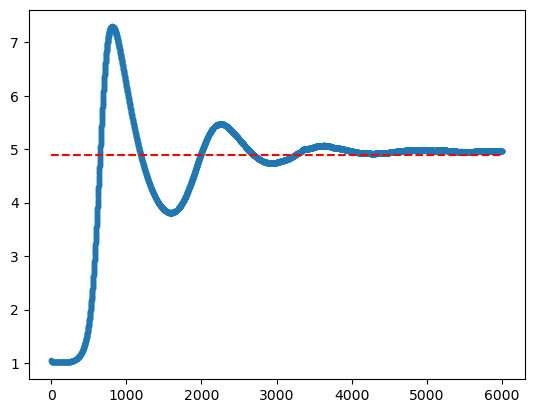

In [17]:
figure()
plot(t/3.15e7/1e6,nu,".")
plot([0.,6000.],[4.8844,4.8844],"r--")
show()

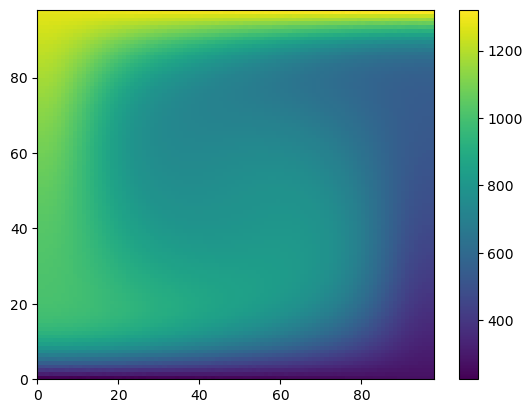

In [18]:
figure()
pcolor(Tlast)
colorbar()
show()
# print(size(Tnew))


In [19]:
figure()
scatter(markers.x[1,:],markers.x[2,:],c=markers.scalars[markers.scalarFields["T",],:],s=0.1)
colorbar()
show()

/Users/max/miniconda3/lib/python3.10/site-packages/matplotlib/colors.py:1368: RuntimeWarning: overflow encountered in double_scalars
  return vmin + val * (vmax - vmin)
/Users/max/miniconda3/lib/python3.10/site-packages/matplotlib/colors.py:1354: RuntimeWarning: overflow encountered in double_scalars
  resdat /= (vmax - vmin)
/Users/max/miniconda3/lib/python3.10/site-packages/matplotlib/colors.py:1354: RuntimeWarning: invalid value encountered in divide
  resdat /= (vmax - vmin)


LoadError: PyError ($(Expr(:escape, :(ccall(#= /Users/max/.julia/packages/PyCall/twYvK/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'ValueError'>
ValueError('Axis limits cannot be NaN or Inf')
  File "/Users/max/miniconda3/lib/python3.10/site-packages/matplotlib/pyplot.py", line 2065, in colorbar
    ret = gcf().colorbar(mappable, cax=cax, ax=ax, **kwargs)
  File "/Users/max/miniconda3/lib/python3.10/site-packages/matplotlib/figure.py", line 1277, in colorbar
    cb = cbar.Colorbar(cax, mappable, **cb_kw)
  File "/Users/max/miniconda3/lib/python3.10/site-packages/matplotlib/_api/deprecation.py", line 384, in wrapper
    return func(*inner_args, **inner_kwargs)
  File "/Users/max/miniconda3/lib/python3.10/site-packages/matplotlib/colorbar.py", line 396, in __init__
    self._draw_all()
  File "/Users/max/miniconda3/lib/python3.10/site-packages/matplotlib/colorbar.py", line 545, in _draw_all
    self.ax.set_ylim(lower, upper)
  File "/Users/max/miniconda3/lib/python3.10/site-packages/matplotlib/_api/deprecation.py", line 454, in wrapper
    return func(*args, **kwargs)
  File "/Users/max/miniconda3/lib/python3.10/site-packages/matplotlib/axes/_base.py", line 3925, in set_ylim
    return self.yaxis._set_lim(bottom, top, emit=emit, auto=auto)
  File "/Users/max/miniconda3/lib/python3.10/site-packages/matplotlib/axis.py", line 1112, in _set_lim
    v0 = self.axes._validate_converted_limits(v0, self.convert_units)
  File "/Users/max/miniconda3/lib/python3.10/site-packages/matplotlib/axes/_base.py", line 3613, in _validate_converted_limits
    raise ValueError("Axis limits cannot be NaN or Inf")


In [20]:
minimum(markers.scalars[markers.scalarFields["T"],:])

NaN